In [22]:
# Computation imports
import numpy as np
import pandas as pd
# Dataviz imports
import matplotlib.pyplot as plt
import seaborn as sns
# Our developed modules
from services import RiskScoringDataPreparator
from services.imputers import MiceImputer
from models import MethaneScoreDocumentModel
from api.db import RiskScoresDbController

In [157]:
# filter noisy warnings
import warnings
warnings.filterwarnings("ignore")

### 1) Recover the Methane emissions values for all countries and for all years:

In [3]:
WORLD_BANK_INDICATOR_IDS = ("EN.ATM.METH.EG.ZS", "EG.ELC.NGAS.ZS",
                                "EG.USE.COMM.CL.ZS", "EN.ATM.CO2E.KT",
                                "EG.FEC.RNEW.ZS", "EG.ELC.ACCS.ZS",
                                "EG.USE.COMM.FO.ZS", "EN.ATM.CO2E.GF.ZS",
                                "EG.EGY.PRIM.PP.KD", "EG.USE.PCAP.KG.OE",
                                "EN.ATM.METH.AG.KT.CE", "NY.GDP.PCAP.CD",
                                "SP.POP.TOTL")
METHANE_INDICATOR_ID = "EN.ATM.METH.KT.CE"
# Use our developed module for data preparation. Filters and transforms data to return values for each indicator
# in a pandas dataframe format
data_preparator = RiskScoringDataPreparator(main_indicator_id=METHANE_INDICATOR_ID, 
                          imputation_indicators_ids=WORLD_BANK_INDICATOR_IDS)
data_preparator.prepare_indicators_data()

In [5]:
# Preview of methane values for all countries and for all years
# (215 actual countries / Emissions for 62 years [1960-2021])
data_preparator.full_df[["country_name", METHANE_INDICATOR_ID]].head(10)

country_name  EN.ATM.METH.KT.CE
country_id date                                
AF         2021  Afghanistan                NaN
           2020  Afghanistan                NaN
           2019  Afghanistan       16370.000839
           2018  Afghanistan       15909.999847
           2017  Afghanistan       15609.999657
           2016  Afghanistan       15829.999924
           2015  Afghanistan       15960.000038
           2014  Afghanistan       16299.999237
           2013  Afghanistan       15819.999695
           2012  Afghanistan       15630.000114

In [52]:
# filter out countries with completely missing Methane Emissions
methane_filling_per_country = data_preparator.full_df.groupby("country_name")[METHANE_INDICATOR_ID].count()
# here is another list of countries that we will filter out, for not having any Methane Emissions history
countries_missing_methane_emissions = methane_filling_per_country[methane_filling_per_country==0].index
countries_missing_methane_emissions

Index(['American Samoa', 'Aruba', 'Bermuda', 'British Virgin Islands',
       'Cayman Islands', 'Curacao', 'Faroe Islands', 'French Polynesia',
       'Gibraltar', 'Greenland', 'Guam', 'Hong Kong SAR, China', 'Isle of Man',
       'Macao SAR, China', 'Monaco', 'New Caledonia',
       'Northern Mariana Islands', 'Puerto Rico', 'San Marino',
       'Sint Maarten (Dutch part)', 'St. Martin (French part)',
       'Turks and Caicos Islands', 'Virgin Islands (U.S.)',
       'West Bank and Gaza'],
      dtype='object', name='country_name')

In [53]:
# filter them out
new_full_df = data_preparator.full_df[~data_preparator.full_df.country_name.isin(countries_missing_methane_emissions)].copy()

In [56]:
f"{new_full_df.country_id.nunique()} remaining countries data"

'191 remaining countries data'

### 2) Give an estimate on the Methane emissions for countries where the information is missing and justify the approach used:
To impute Methan emissions values, we can think of multiple methods: 

- Simple univariate imputation for each country (mean, median...).
- Forecasting: Use a forecasting method like ARIMA for each country to predict missing data points.

Using any of the lastest does not account for a lot of variables describing a country's developement, growth and policies regarding environnemental issues. Methane emissions depend on a lot those variable indicators. Thus, we suggest the use of some of those country indicators that can directely or indirectly influence the level of Methane emissions:

- `EN.ATM.METH.EG.ZS`: Energy related methane emissions (% of total)
- `EG.ELC.NGAS.ZS`: Electricity production from natural gas sources (% of total)
- `EG.USE.COMM.CL.ZS`: Alternative and nuclear energy (% of total energy use)
- `EN.ATM.CO2E.KT`: CO2 emissions (kt)
- `EN.ATM.METH.KT.CE`: Methane emissions (kt of CO2 equivalent)
- `EG.FEC.RNEW.ZS`: Renewable energy consumption (% of total final energy consumption)
- `EG.ELC.ACCS.ZS`: Access to electricity (% of population)
- `EG.USE.COMM.FO.ZS`: Fossil fuel energy consumption (% of total)
- `EN.ATM.CO2E.GF.ZS`: CO2 emissions from gaseous fuel consumption (% of total)
- `EG.EGY.PRIM.PP.KD`: Energy intensity level of primary energy (MJ/2017 PPP GDP)
- `EG.USE.PCAP.KG.OE`: Energy use (kg of oil equivalent per capita)
- `EN.ATM.METH.AG.KT.CE`: Agricultural methane emissions (thousand metric tons of CO2 equivalent)
- `NY.GDP.PCAP.CD`: GDP per capita (current US$)
- `SP.POP.TOTL`: Population, total

Therefore, we suggest using a multivariate imputation method. More specifically we will use the iterative algorithm of `Multiple Imputation by Chained Equations (MICE)`. We will use the experimental version provided in `scikit-learn` and as an estimator we will go with the default BayesianRidge model (More analysis could be done later to fine-tune the choice of the estimator). Given the fact that the indicator features does also contain missing values, we will drop completely missing features for a country when running the MICE algorithm in order to reduce uncertainty. Finally, we will run the imputation process multiple times and keep the mean value as the final imputation value (details in the uncertainty measure bellow)

### 3) Compute the uncertainty on your estimation when the value is missing

To compute a measure of uncertainty for each imputed value we will introduce randomization in the imputation process for each country by allowing the sampling from the predictive posterior of the fitted estimator. Then we compute our uncertainty measure as `the standard deviation of the imputation measures` for each value. This is a good measure of dispersion and so of uncertainty (We also can provide the one sample confidence interval as a measure of incertainty `[mean_value-1.96*standard_deviation, mean_value+1.96*standard_deviation]`)


`Note`: You may see that the multiple imputation with MICE is ressource heavy, especially that we conduct multiple imputations in order to have a better estimation of the missing data and reduce uncertainty. We can imporve the imputation execution time using a `GPU` or go for less costly methods later.

In [57]:
# get non empty features for each country
value_counts_of_features = new_full_df.groupby("country_name").count()
imputation_features_per_country = {}
for country_id in  value_counts_of_features.index:
    populated_features = value_counts_of_features.loc[country_id][value_counts_of_features.loc[country_id]>0].index.tolist()
    populated_features = [feature for feature in populated_features 
                                                 if feature not in ("country_id", "date")]
    if METHANE_INDICATOR_ID not in populated_features:
        populated_features = [METHANE_INDICATOR_ID] + populated_features
    imputation_features_per_country[country_id] = populated_features

In [59]:
ignore_cols = ["country_id", "country_name", "date"]
def get_imputation_result_for_country(country_name, max_iter=5, random_state=0):
    features = imputation_features_per_country[country_name]
    df_country = new_full_df[new_full_df.country_name==country_name].copy()
    df_country_ignored_cols = df_country[ignore_cols].copy()
    df_country = df_country[features].astype("float")
    # impute the data
    imputer_params = {"max_iter": max_iter, "random_state": random_state,
                     "sample_posterior": True}
    country_imputer = MiceImputer(df_country, imputer_params)
    country_imputer.impute()
    df_country_imputed = country_imputer.imputed_df.copy()
    # reintegrate date and country columns
    for column in ignore_cols:
        df_country_imputed[column] = df_country_ignored_cols[column].values
    return df_country_imputed, country_imputer

imputation_dfs = []
imputation_iterations = 10
for _ in range(imputation_iterations):
    country_dfs = []    
    for country_name in new_full_df.country_name.unique():
        df_country_imputed, country_imputer = get_imputation_result_for_country(country_name)
        country_dfs.append(df_country_imputed)
    df_imputed_per_country = pd.concat(country_dfs, axis=0).set_index(["country_id", "date"])
    imputation_dfs.append(df_imputed_per_country)

In [179]:
new_full_df

country_id country_name  date  EN.ATM.METH.KT.CE  \
country_id date                                                    
AF         2021         AF  Afghanistan  2021                NaN   
           2020         AF  Afghanistan  2020                NaN   
           2019         AF  Afghanistan  2019       16370.000839   
           2018         AF  Afghanistan  2018       15909.999847   
           2017         AF  Afghanistan  2017       15609.999657   
...                    ...          ...   ...                ...   
ZW         1964         ZW     Zimbabwe  1964                NaN   
           1963         ZW     Zimbabwe  1963                NaN   
           1962         ZW     Zimbabwe  1962                NaN   
           1961         ZW     Zimbabwe  1961                NaN   
           1960         ZW     Zimbabwe  1960                NaN   

                 EN.ATM.METH.EG.ZS  EG.ELC.NGAS.ZS  EG.USE.COMM.CL.ZS  \
country_id date                                                         
AF         2021                NaN             NaN                NaN   
           2020                NaN             NaN                NaN   
           2019                NaN             NaN                NaN   
           2018                NaN             NaN                NaN   
           2017                NaN             NaN                NaN   
...                            ...             ...                ...   
ZW         1964                NaN             NaN                NaN   
           1963                NaN             NaN                NaN   
           1962                NaN             NaN                NaN   
           1961                NaN             NaN                NaN   
           1960                NaN             NaN                NaN   

                 EN.ATM.CO2E.KT  EG.FEC.RNEW.ZS  EG.ELC.ACCS.ZS  \
country_id date                                                   
AF         2021             NaN             NaN             NaN   
           2020             NaN             NaN       97.699997   
           2019     6079.999924           18.51       97.699997   
           2018     6070.000172           17.96       96.616135   
           2017     4780.000210           19.21       97.699997   
...                         ...             ...             ...   
ZW         1964             NaN             NaN             NaN   
           1963             NaN             NaN             NaN   
           1962             NaN             NaN             NaN   
           1961             NaN             NaN             NaN   
           1960             NaN             NaN             NaN   

                 EG.USE.COMM.FO.ZS  EN.ATM.CO2E.GF.ZS  EG.EGY.PRIM.PP.KD  \
country_id date                                                            
AF         2021                NaN                NaN                NaN   
           2020                NaN                NaN                NaN   
           2019                NaN                NaN               2.41   
           2018                NaN                NaN               2.44   
           2017                NaN                NaN               2.30   
...                            ...                ...                ...   
ZW         1964                NaN                0.0                NaN   
           1963                NaN                NaN                NaN   
           1962                NaN                NaN                NaN   
           1961                NaN                NaN                NaN   
           1960                NaN                NaN                NaN   

                 EG.USE.PCAP.KG.OE  EN.ATM.METH.AG.KT.CE  NY.GDP.PCAP.CD  \
country_id date                                                            
AF         2021                NaN                   NaN      368.754614   
           2020                NaN                   NaN      516.866552   
           2019 

In [361]:
# set the imputation values and their associated uncertainty measure, in addition to estimation status
# Add also metadata (date, country name, ...)
index_values = imputation_dfs[0].index
output_payload = {"value": [], "value_uncertainty": [], "estimated": []}
for idx in index_values:
    methane_value = new_full_df[METHANE_INDICATOR_ID].loc[idx]
    if np.isnan(methane_value):
        value_measures = [df[METHANE_INDICATOR_ID].loc[idx] for df in imputation_dfs]
        output_payload["value"].append(np.mean(value_measures))
        output_payload["value_uncertainty"].append(np.std(value_measures))
        output_payload["estimated"].append(True)
    else:
        output_payload["value"].append(methane_value)
        output_payload["value_uncertainty"].append(0)
        output_payload["estimated"].append(False)
emissions_df = pd.DataFrame(output_payload)

# add metadata columns
for column in ignore_cols:
    emissions_df[column] = new_full_df[column].values
emissions_df["date"] = emissions_df["date"].astype(int)
    
emissions_df

,value,value_uncertainty,estimated,country_id,country_name,date
0,16021.729380,0.000000e+00,True,AF,Afghanistan,2021
1,16043.399432,0.000000e+00,True,AF,Afghanistan,2020
2,16370.000839,0.000000e+00,False,AF,Afghanistan,2019
3,15909.999847,0.000000e+00,False,AF,Afghanistan,2018
4,15609.999657,0.000000e+00,False,AF,Afghanistan,2017
...,...,...,...,...,...,...
11837,13054.148630,0.000000e+00,True,ZW,Zimbabwe,1964
11838,15219.440745,1.818989e-12,True,ZW,Zimbabwe,1963
11839,10435.052070,1.818989e-12,True,ZW,Zimbabwe,1962
11840,16390.385164,0.000000e+00,True,ZW,Zimbabwe,1961


In [144]:
df_imputed = new_full_df.copy()
df_imputed[METHANE_INDICATOR_ID] = emissions_df["value"].values
df_imputed["date"] = df_imputed["date"].astype(int)

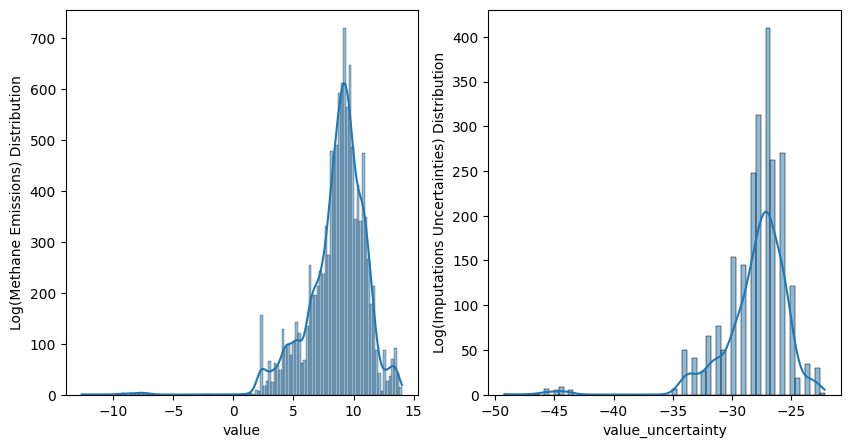

In [129]:
fig, axes = plt.subplots(1, 2, figsize=(10,5))
axes = axes.flatten()
sns.histplot(np.log(emissions_df["value"]), kde=True, ax=axes[0])
axes[0].set_ylabel("Log(Methane Emissions) Distribution")
sns.histplot(np.log(emissions_df["value_uncertainty"]), kde=True, ax=axes[1])
axes[1].set_ylabel("Log(Imputations Uncertainties) Distribution")
plt.show()

### 4) Obtain and estimate, when possible, of the Methane emissions for the last 10 years in all countries

This is simply done for the last 10 years on the imputed data.

In [275]:
nbr_years = 10
# filter imputed dataframe to get last `nbr_years` years
last_nbr_years = df_imputed['date'].max()-nbr_years+1
filtered_df = df_imputed[df_imputed['date'] >= last_nbr_years]
# Group by country and sum the quantity
emissions_per_country_for_last_nbr_years = filtered_df.groupby('country_name').agg({METHANE_INDICATOR_ID:
                                                                                          'sum'})
emissions_per_country_for_last_nbr_years = emissions_per_country_for_last_nbr_years.sort_values(by=METHANE_INDICATOR_ID, ascending=False) 
emissions_per_country_for_last_nbr_years

,EN.ATM.METH.KT.CE
country_name,
China,1.159745e+07
United States,6.732653e+06
India,6.419337e+06
Russian Federation,6.305686e+06
Brazil,4.214452e+06
...,...
Palau,1.947160e+02
Sao Tome and Principe,1.000007e+02
Tuvalu,1.000002e+02


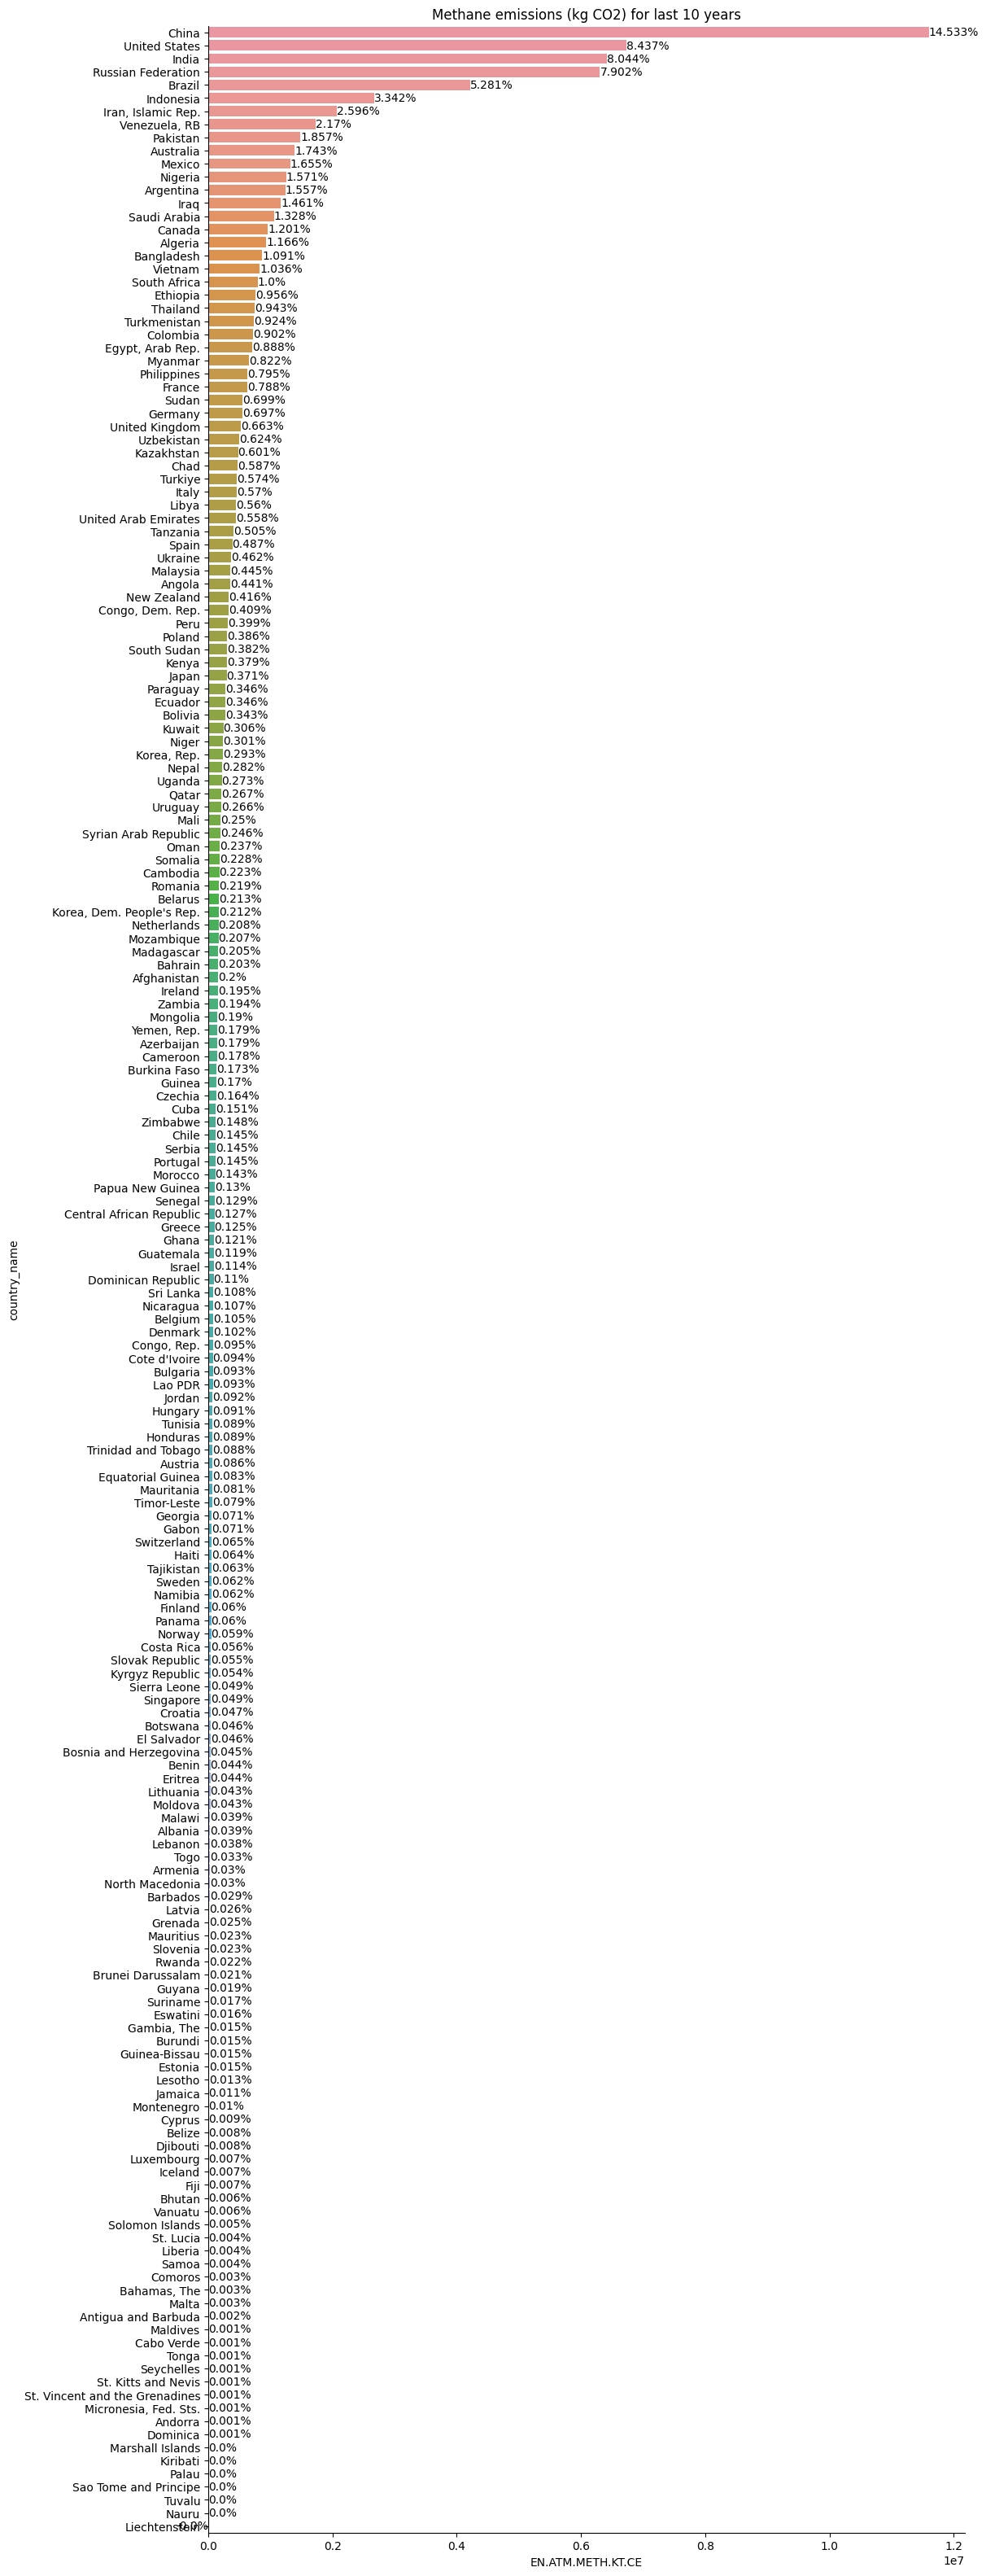

In [276]:
def plot_discrete_distribution(x, y, show_percent=True,
                               figsize=(15,6), ax_params=None, title=None):
    fmt_percent = lambda x: f"{round(x, 3)}%"
    if ax_params is None:
        ax_params = {"orient": "h"}
    _, ax = plt.subplots(1, 1, figsize=figsize)
    sns.barplot(x=x, y=y, ax=ax, **ax_params)
    ax.set_title(label=x.name if title is None else title)
    if show_percent:
        labels = list(map(fmt_percent, 100*ax.containers[0].datavalues/ax.containers[0].datavalues.sum()))
    else:
        labels = ax.containers[0].datavalues
    ax.bar_label(ax.containers[0], labels=labels)
    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)
    
plot_discrete_distribution(y=emissions_per_country_for_last_nbr_years.index,
                           x=emissions_per_country_for_last_nbr_years[METHANE_INDICATOR_ID],
                           figsize=(12,40),
                           title="Methane emissions (kg CO2) for last 10 years")

### 5) Give an estimate of the Methane emissions for all countries for the next 5 years

To do so we use an additive exponential model. For this question, there has not been a lot of model comparisons or evaluation, neither assumptions validation. More advanced models like `Vector Autoregression, ARIMA...` are to be evaluated for better forecasting. For the sake of simplicity we choose this model for the first version of the API.

In [156]:
def prepare_forcasting_train_df(country_name):
    country_df = df_imputed[df_imputed.country_name == country_name]
    train_df = country_df.copy()
    train_df['date'] = train_df['date'].apply(lambda date: f"{date}-01-01")
    train_df["date"] = pd.to_datetime(train_df['date'])
    train_df = train_df.set_index("date")
    train_df = train_df[[METHANE_INDICATOR_ID]]
    train_df = train_df.sort_index()
    train_df.index.freq = pd.infer_freq(train_df.index)
    return train_df

In [160]:
import pandas as pd
from statsmodels.tsa.holtwinters import ExponentialSmoothing
import matplotlib.pyplot as plt

forcast_years = 5
unique_country_names = df_imputed.country_name.unique()
forcasts_object = {}
for country_name in unique_country_names:
    country_train_df = prepare_forcasting_train_df(country_name)
    # Fit the VAR model
    model = ExponentialSmoothing(country_train_df, trend='add')
    model_fit = model.fit()
    # Make a forecast for the next 5 years
    forecast = model_fit.forecast(steps=forcast_years)
    forcasts_object[country_name] = {"forecast": forecast, "model": model_fit}

In [253]:
# get methane emissions for next year for a given Country 
country_name = "Brazil"
country_methane_next_5years = pd.DataFrame(forcasts_object[country_name]["forecast"], 
             columns=country_train_df.columns, 
             index=[f"{i+2022}-01-01" for i in range(forcast_years)])[[METHANE_INDICATOR_ID]]

In [254]:
country_methane_next_5years

,EN.ATM.METH.KT.CE
2022-01-01,406964.008601
2023-01-01,407287.999656
2024-01-01,407611.990712
2025-01-01,407935.981767
2026-01-01,408259.972823


### 6) Provide a score related to the Methane emissions value in each country, justify the methodology used. The score should be an index going from 0 to 10, where 0 stands for a “good” environmental result and 10 for the ”worst” environmental result. 

There are multiple approaches to choosing a score. Our approach will mainly take into account the emissions for the last 10 years to keep it representative of the present of each country. To avoid uncertainty effect on the score, we will not be using our forecasting data in the score. We choose also to integrate the emissions per capita in order to penalize more small countries with high emissions (like Qatar) and not be harsh with highly populated countries. For that, we heuristically choose that the emissions for the last 10 years would account for 90% of the score and the emissions per capita for 10% of the score. We compute the percentile for the countries emissions in the last 10 years and the emissions per capita percentile for the last 10 years too.

In [315]:
emissions_percentiles = emissions_per_country_for_last_nbr_years.rank(pct=True)[METHANE_INDICATOR_ID]
population_df = df_imputed.copy()[(df_imputed.date<=2021) & (df_imputed.date>=2012)]
population_df["emissions_per_capita"] = population_df[METHANE_INDICATOR_ID]/population_df["SP.POP.TOTL"]
per_capita_percentiles = population_df.groupby(["country_name"])["emissions_per_capita"].mean().rank(pct=True)
emissions_per_capita_percentiles = per_capita_percentiles.reindex(emissions_percentiles.index)

In [358]:
final_score = 9*emissions_percentiles+1*emissions_per_capita_percentiles
final_score = final_score.sort_values(ascending=False).apply(np.rint).astype(int)

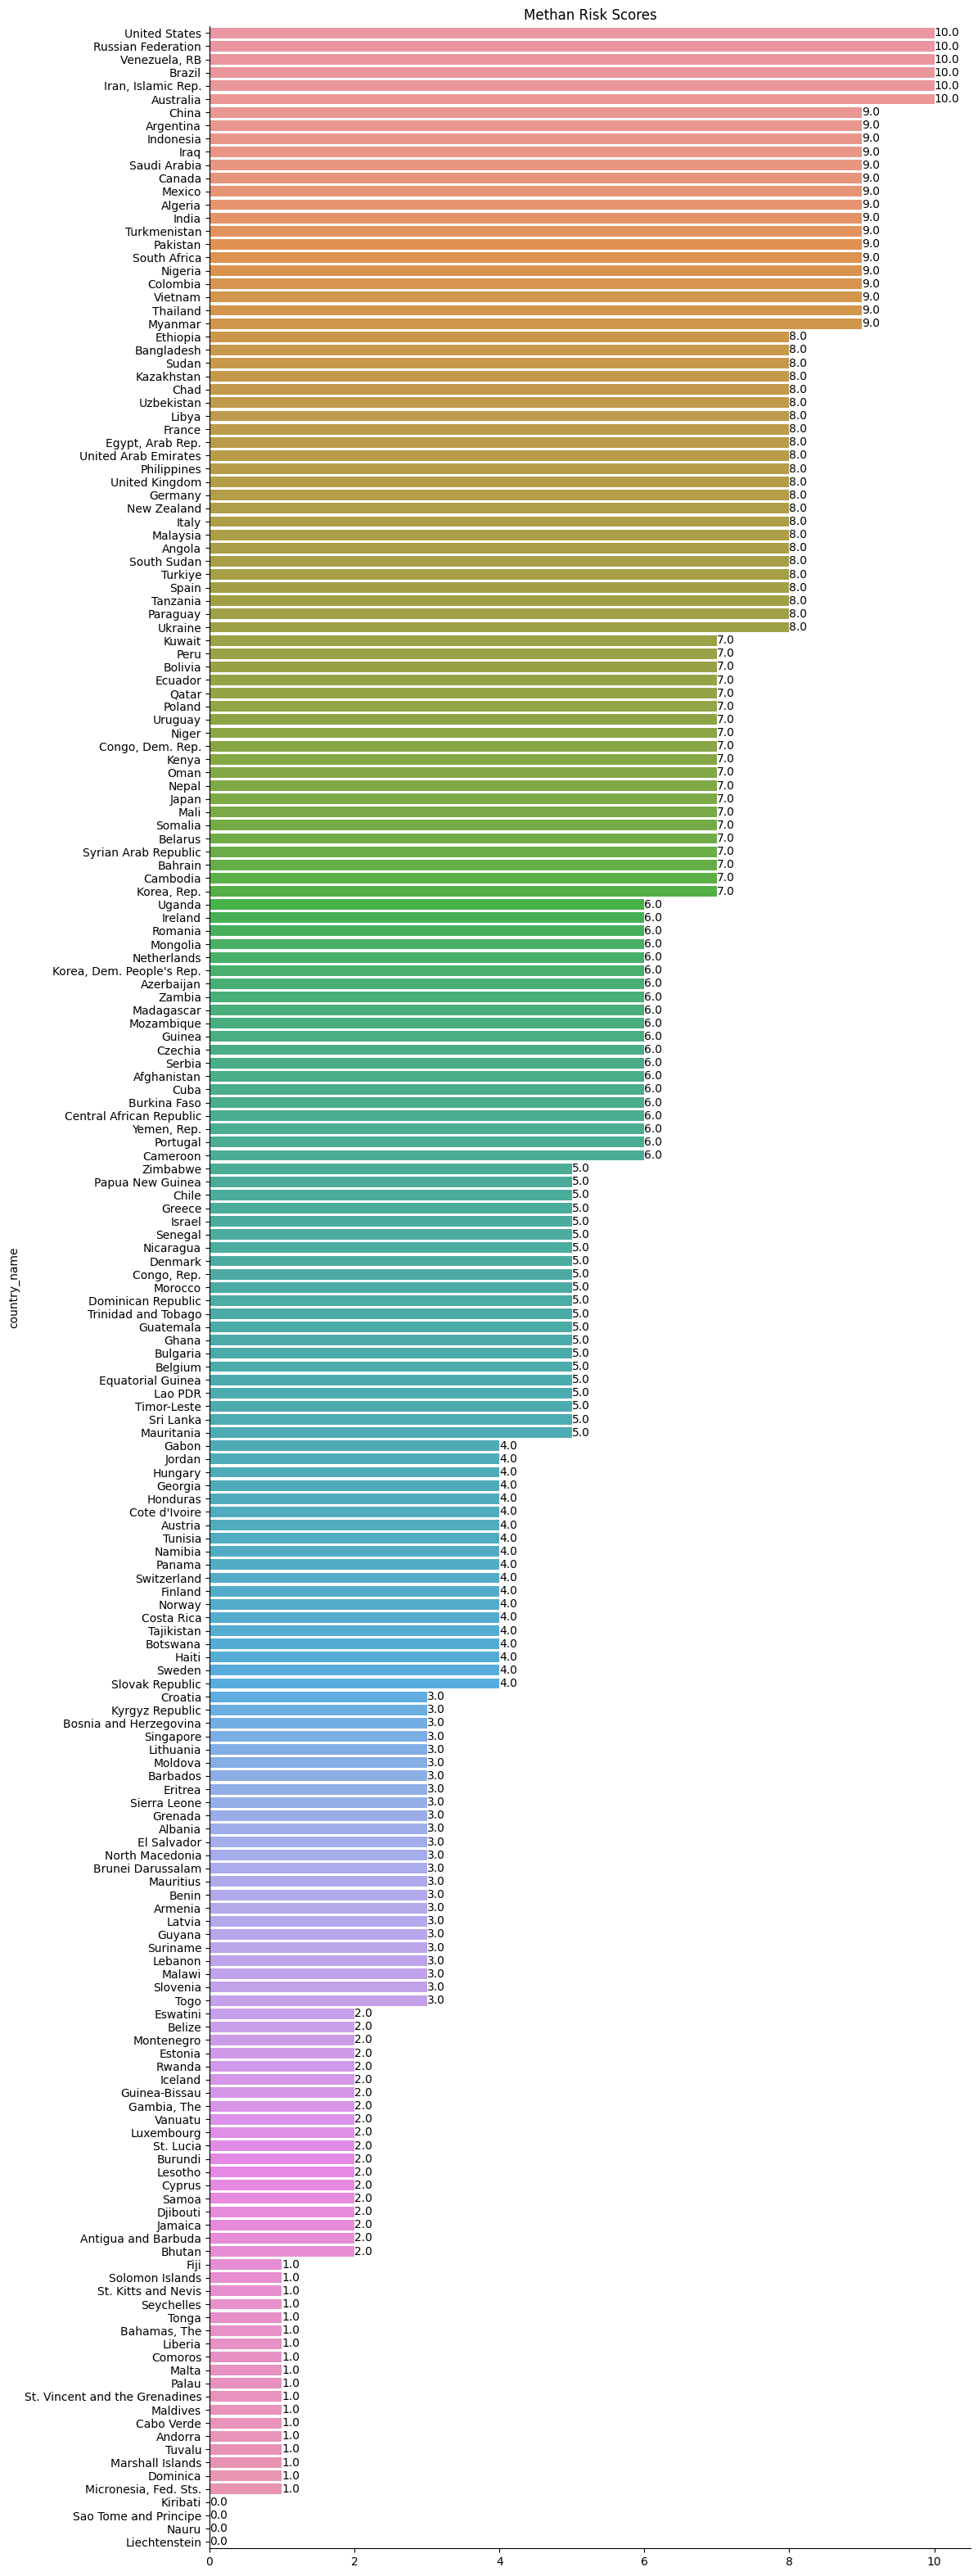

In [359]:
plot_discrete_distribution(y=final_score.index,
                           x=final_score,
                           show_percent=False,
                           figsize=(12,40),
                           title="Methan Risk Scores")

## Store data for the API:
For this part, we need to store countries records of the Methan Emissions risk score for each year. We might want to store other metadata as we go forward with the developement of new versions of the API. This implies frequent changes of the data model, in addition to the potential use of nested structures for each record. For those reasons, a document based storage is prefered.

Thus we will be using a `MongoDB` database.

For this case study, I used a local mongo database created on a docker container to store the data. The container was created from an official mongo db image.

Now that we prepared our measures and our score, we will store the data in a collection `methaneScores` we create inside our database `riskScoresDb`.

Below is the script to format and store the data.

In [362]:
# Create records
records = []
for idx in emissions_df.index:
    country_name = emissions_df.country_name.loc[idx]
    document = {
        "alpha2code": emissions_df.country_id.loc[idx],
        "year": emissions_df.date.loc[idx],
        "country_name": country_name,
        "value": emissions_df.value.loc[idx],
        "value_uncertainty": emissions_df.value_uncertainty.loc[idx],
        "estimated": emissions_df.estimated.loc[idx],
        "score_index": final_score[country_name],
    }
    records.append(document)

In [367]:
# insert records to local MongoDB database
for record in records:
    RiskScoresDbController.insert_record(MethaneScoreDocumentModel(**record))

`Mongo Shell preview:`

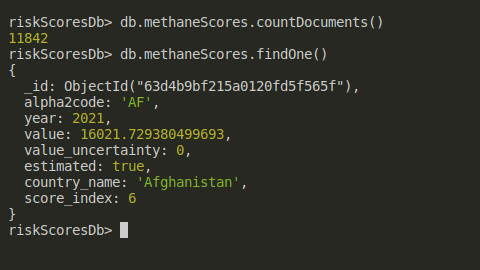